In [1]:
import torch
import torchaudio
from torch.utils.data import DataLoader
import pathlib

# Resources of audio preprocessing functions
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

In [25]:
# Load LJSpeech locally
root = pathlib.Path('/Users/lukgar/Desktop/exjobb/datasets')
ljspeech = torchaudio.datasets.LJSPEECH(root, download=False)
data_loader = DataLoader(ljspeech, batch_size=1, shuffle=False)

In [51]:
# Get 4th file in data_loader
for i, data in enumerate(data_loader):
    if i == 3:
        break
waveform = data[0].squeeze(0)
sample_rate = data[1].item()

In [40]:
# Get a random audio file
data = next(iter(data_loader))
print(len(data))
waveform = data[0]
sample_rate = data[1]
waveform = waveform.squeeze(0)
sample_rate = sample_rate.item()
print(waveform.shape)
print(sample_rate)

4
torch.Size([1, 212893])
22050


In [35]:
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [52]:
play_audio(waveform, sample_rate)

In [11]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

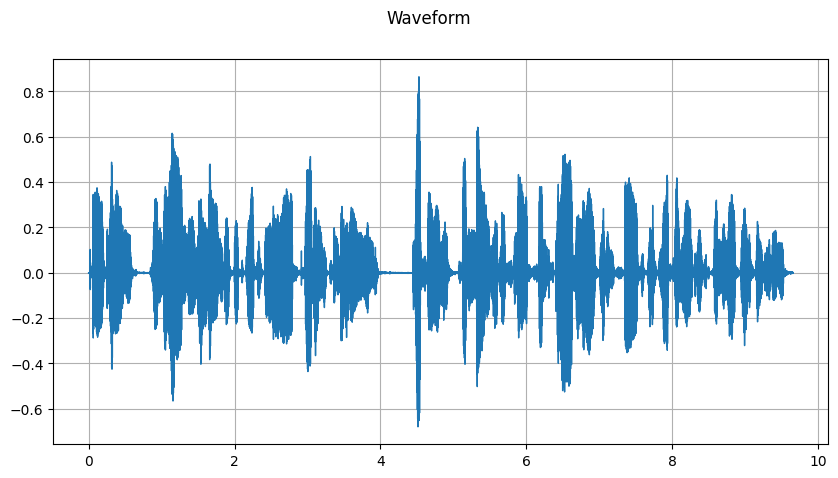

In [12]:
# Increase size of figure
plt.rcParams['figure.figsize'] = [10, 5]
plot_waveform(waveform, sample_rate)

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

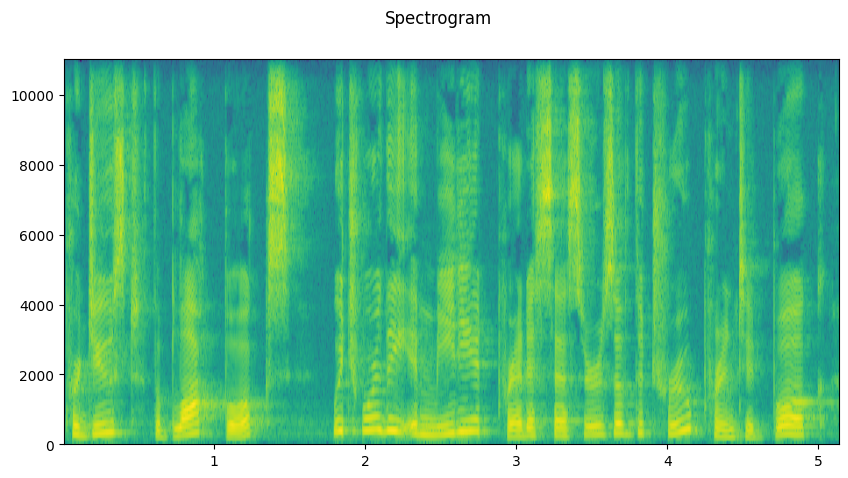

In [45]:
plot_specgram(waveform, sample_rate)

In [47]:
import torchaudio.transforms as T
def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _, _, _ = next(iter(data_loader))
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)



In [48]:
import scipy
import librosa
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

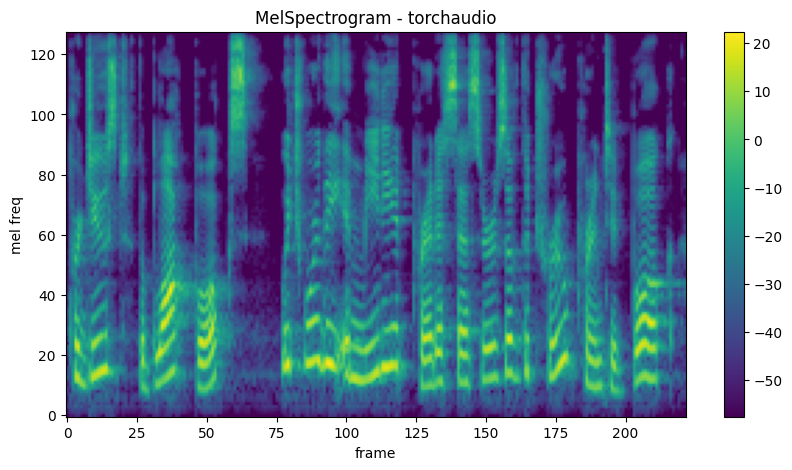

In [49]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

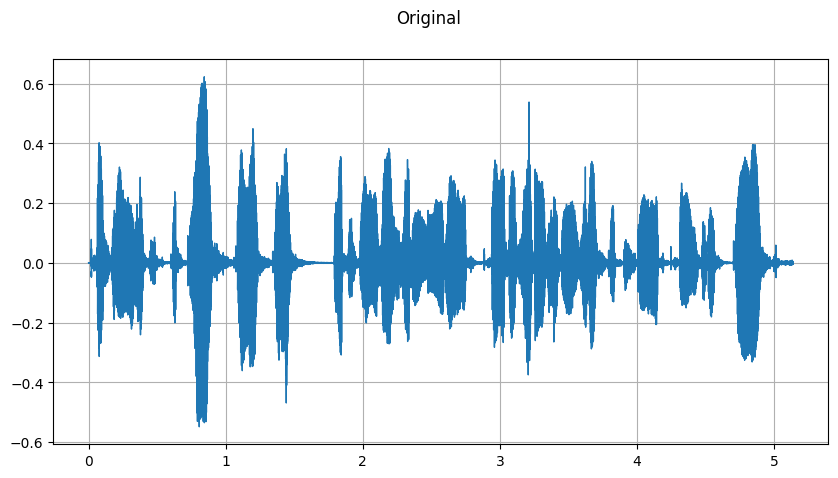

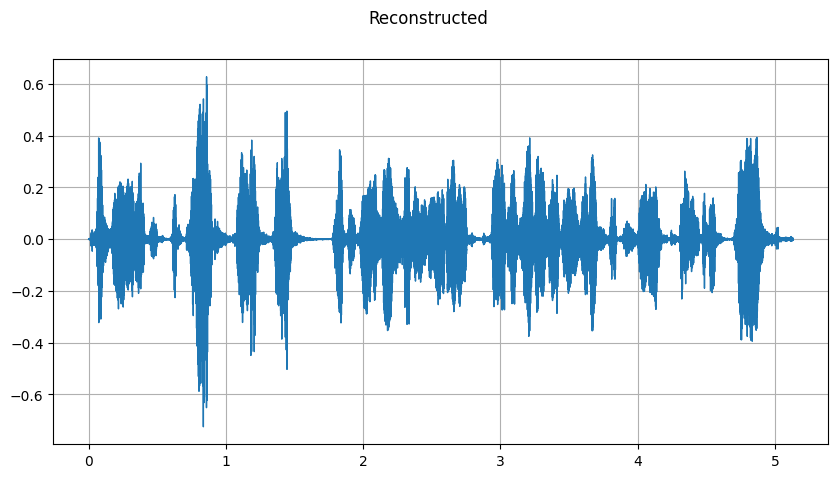

In [53]:
torch.random.manual_seed(0)
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform_gm = griffin_lim(spec)

plot_waveform(waveform_gm, sample_rate, title="Reconstructed")
play_audio(waveform_gm, sample_rate)

In [ ]:
# Save waveform_gm to file
torchaudio.save("waveform_gm.wav", waveform_gm, sample_rate)